<a href="https://colab.research.google.com/github/cghart/batch_invariant_ops/blob/main/notebooks/batch_invariant_ops_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Batch Invariant Operations - Google Colab Demo

This notebook demonstrates the batch-invariant-ops library, which provides deterministic GPU operations that produce identical results regardless of batch size.

**Important**: Make sure you're using a GPU runtime:
- Go to Runtime → Change runtime type → Hardware accelerator: GPU
- Recommended: T4 GPU (free) or better (Colab Pro)

## 🚀 Setup & GPU Verification

In [1]:
# Check GPU availability and specifications
import subprocess
import sys

# Check if nvidia-smi is available
try:
    result = subprocess.run(['nvidia-smi'], capture_output=True, text=True)
    print("🎯 GPU Information:")
    print(result.stdout)
except FileNotFoundError:
    print("❌ No GPU detected! Please enable GPU runtime:")
    print("   Runtime → Change runtime type → Hardware accelerator: GPU")
    sys.exit(1)

🎯 GPU Information:
Sun Sep 21 23:21:32 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   53C    P8             10W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+----------------------------

In [2]:
# Check PyTorch and CUDA
import torch
print(f"🐍 Python version: {sys.version}")
print(f"🔥 PyTorch version: {torch.__version__}")
print(f"🚀 CUDA available: {torch.cuda.is_available()}")

if torch.cuda.is_available():
    print(f"🎮 GPU device: {torch.cuda.get_device_name(0)}")
    print(f"💾 GPU memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")
    print(f"🔧 CUDA version: {torch.version.cuda}")
    print(f"🏗️ CuDNN version: {torch.backends.cudnn.version()}")
else:
    print("❌ CUDA not available! Please check GPU runtime setting.")
    sys.exit(1)

🐍 Python version: 3.12.11 (main, Jun  4 2025, 08:56:18) [GCC 11.4.0]
🔥 PyTorch version: 2.8.0+cu126
🚀 CUDA available: True
🎮 GPU device: Tesla T4
💾 GPU memory: 15.8 GB
🔧 CUDA version: 12.6
🏗️ CuDNN version: 91002


## 📦 Installation

In [3]:
# Clone the repository
!git clone https://github.com/cghart/batch_invariant_ops.git
%cd batch_invariant_ops

Cloning into 'batch_invariant_ops'...
remote: Enumerating objects: 22, done.
remote: Counting objects: 100% (22/22), done.
remote: Compressing objects: 100% (20/20), done.
remote: Total 22 (delta 2), reused 22 (delta 2), pack-reused 0 (from 0)
Receiving objects: 100% (22/22), 32.04 KiB | 6.41 MiB/s, done.
Resolving deltas: 100% (2/2), done.
/content/batch_invariant_ops


In [4]:
# Install Triton (required for kernels)
!pip install triton -q

# Install the library in development mode
!pip install -e . -q

# Install visualization dependencies
!pip install matplotlib seaborn pandas -q

print("✅ Installation complete!")

  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
  Building editable for batch-invariant-ops (pyproject.toml) ... done
✅ Installation complete!


## 🔍 Environment Validation

In [5]:
# Test imports
try:
    import batch_invariant_ops
    from batch_invariant_ops import (
        set_batch_invariant_mode,
        is_batch_invariant_mode_enabled,
        matmul_persistent,
        log_softmax,
        mean_dim
    )
    print(f"✅ Library imported successfully! Version: {batch_invariant_ops.__version__}")
except ImportError as e:
    print(f"❌ Import failed: {e}")
    sys.exit(1)

✅ Library imported successfully! Version: 0.1.0


In [6]:
# Quick functionality test
torch.set_default_device('cuda')

# Test batch-invariant mode enablement
print(f"📊 Initial batch-invariant mode: {is_batch_invariant_mode_enabled()}")

with set_batch_invariant_mode(True):
    print(f"📊 Batch-invariant mode enabled: {is_batch_invariant_mode_enabled()}")

    # Quick test with small tensors
    a = torch.randn(4, 4)
    b = torch.randn(4, 4)
    c = torch.mm(a, b)
    print(f"✅ Test matrix multiplication successful! Shape: {c.shape}")

print(f"📊 Final batch-invariant mode: {is_batch_invariant_mode_enabled()}")
print("🎉 Environment validation complete!")

📊 Initial batch-invariant mode: False
📊 Batch-invariant mode enabled: True


/usr/local/lib/python3.12/dist-packages/torch/library.py:381: UserWarning: Warning only once for all operators,  other operators may also be overridden.
  Overriding a previously registered kernel for the same operator and the same dispatch key
  operator: aten::mm(Tensor self, Tensor mat2) -> Tensor
    registered at /pytorch/build/aten/src/ATen/RegisterSchema.cpp:6
  dispatch key: CUDA
  previous kernel: registered at /pytorch/aten/src/ATen/LegacyBatchingRegistrations.cpp:1079
       new kernel: registered at /dev/null:502 (Triggered internally at /pytorch/aten/src/ATen/core/dispatch/OperatorEntry.cpp:218.)
  self.m.impl(


✅ Test matrix multiplication successful! Shape: torch.Size([4, 4])
📊 Final batch-invariant mode: False
🎉 Environment validation complete!


## 🎯 Batch Invariance Demo

This section demonstrates the core concept: standard PyTorch operations can produce different results depending on batch size due to floating-point precision and execution order, while batch-invariant operations produce identical results.

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Set up the demo data
torch.set_default_device('cuda')
torch.manual_seed(42)  # For reproducibility

def test_batch_invariance_detailed():
    """Detailed test showing batch variance in standard PyTorch vs invariance with library"""
    B, D = 1024, 2048  # Batch size, feature dimension

    # Create test data
    a = torch.linspace(-100, 100, B*D, dtype=torch.float32).reshape(B, D)
    b = torch.linspace(-50, 50, D*D, dtype=torch.float32).reshape(D, D)

    results = []

    # Test different batch sizes
    test_sizes = [1, 8, 32, 128, 512, 1024]

    for batch_size in test_sizes:
        if batch_size > B:
            continue

        # Method 1: Process batch_size rows directly
        out1 = torch.mm(a[:batch_size], b)

        # Method 2: Process full batch, then slice
        out2 = torch.mm(a, b)[:batch_size]

        # Calculate difference
        diff = (out1 - out2).abs().max().item()

        results.append({
            'batch_size': batch_size,
            'standard_pytorch_diff': diff,
            'is_identical': diff == 0.0
        })

        print(f"Batch size {batch_size:4d}: Max difference = {diff:.2e} | Identical: {diff == 0.0}")

    return pd.DataFrame(results)

print("🔬 Testing standard PyTorch (may show differences):")
with set_batch_invariant_mode(False):
    standard_results = test_batch_invariance_detailed()

🔬 Testing standard PyTorch (may show differences):
Batch size    1: Max difference = 1.50e+00 | Identical: False
Batch size    8: Max difference = 6.50e+00 | Identical: False
Batch size   32: Max difference = 9.88e+00 | Identical: False
Batch size  128: Max difference = 0.00e+00 | Identical: True
Batch size  512: Max difference = 0.00e+00 | Identical: True
Batch size 1024: Max difference = 0.00e+00 | Identical: True


In [8]:
print("\n🎯 Testing with batch-invariant operations:")
with set_batch_invariant_mode(True):
    invariant_results = test_batch_invariance_detailed()

# Combine results for comparison
combined = pd.merge(standard_results, invariant_results, on='batch_size', suffixes=('_standard', '_invariant'))
print("\n📊 Summary:")
print(combined[['batch_size', 'standard_pytorch_diff', 'is_identical_standard', 'is_identical_invariant']])


🎯 Testing with batch-invariant operations:
Batch size    1: Max difference = 0.00e+00 | Identical: True
Batch size    8: Max difference = 0.00e+00 | Identical: True
Batch size   32: Max difference = 0.00e+00 | Identical: True
Batch size  128: Max difference = 0.00e+00 | Identical: True
Batch size  512: Max difference = 0.00e+00 | Identical: True
Batch size 1024: Max difference = 0.00e+00 | Identical: True

📊 Summary:


KeyError: "['standard_pytorch_diff'] not in index"

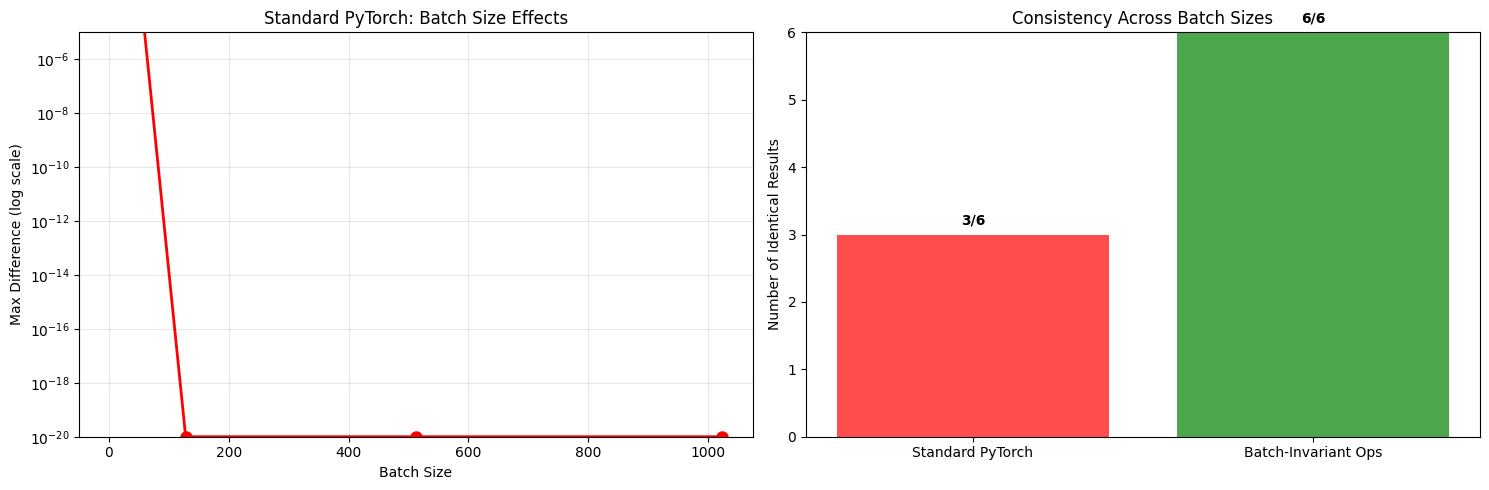


✅ Results: Batch-invariant operations are consistent across 6/6 batch sizes
❌ Standard PyTorch is consistent across 3/6 batch sizes


In [9]:
# Visualize the results
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot 1: Differences in standard PyTorch
ax1.semilogy(combined['batch_size'], combined['standard_pytorch_diff_standard'] + 1e-20, 'o-', color='red', linewidth=2, markersize=8)
ax1.set_xlabel('Batch Size')
ax1.set_ylabel('Max Difference (log scale)')
ax1.set_title('Standard PyTorch: Batch Size Effects')
ax1.grid(True, alpha=0.3)
ax1.set_ylim(1e-20, 1e-5)

# Plot 2: Consistency comparison
consistency_data = {
    'Standard PyTorch': combined['is_identical_standard'].sum(),
    'Batch-Invariant Ops': combined['is_identical_invariant'].sum()
}
bars = ax2.bar(consistency_data.keys(), consistency_data.values(), color=['red', 'green'], alpha=0.7)
ax2.set_ylabel('Number of Identical Results')
ax2.set_title('Consistency Across Batch Sizes')
ax2.set_ylim(0, len(combined))

# Add value labels on bars
for bar, value in zip(bars, consistency_data.values()):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1,
             f'{value}/{len(combined)}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

print(f"\n✅ Results: Batch-invariant operations are consistent across {invariant_results['is_identical'].sum()}/{len(invariant_results)} batch sizes")
print(f"❌ Standard PyTorch is consistent across {standard_results['is_identical'].sum()}/{len(standard_results)} batch sizes")

## 🧪 Comprehensive Testing

Run the full test suite included with the library.

In [10]:
# Run the official test suite
print("🧪 Running official test suite...")
!python test_batch_invariance.py

🧪 Running official test suite...
/usr/local/lib/python3.12/dist-packages/torch/library.py:381: UserWarning: Warning only once for all operators,  other operators may also be overridden.
  Overriding a previously registered kernel for the same operator and the same dispatch key
  operator: aten::mm(Tensor self, Tensor mat2) -> Tensor
    registered at /pytorch/build/aten/src/ATen/RegisterSchema.cpp:6
  dispatch key: CUDA
  previous kernel: registered at /pytorch/aten/src/ATen/LegacyBatchingRegistrations.cpp:1079
       new kernel: registered at /dev/null:502 (Triggered internally at /pytorch/aten/src/ATen/core/dispatch/OperatorEntry.cpp:218.)
  self.m.impl(
Standard PyTorch:
Difference: 9.5
Deterministic: False

Batch-Invariant Mode:
Difference: 0.0
Deterministic: True


## ⚙️ Supported Operations Demo

Test each supported operation individually.

In [11]:
# Test matrix multiplication (mm and addmm)
print("🧮 Testing Matrix Operations:")

def test_operation(op_name, operation, *args):
    """Test an operation with and without batch-invariant mode"""
    torch.manual_seed(42)

    # Standard PyTorch
    with set_batch_invariant_mode(False):
        result_std = operation(*args)

    # Batch-invariant mode
    with set_batch_invariant_mode(True):
        result_inv = operation(*args)

    # Check if results are similar (they should be for single operations)
    diff = (result_std - result_inv).abs().max().item()
    print(f"  {op_name}: difference = {diff:.2e}")
    return result_std, result_inv, diff

# Matrix multiplication
a = torch.randn(128, 256, device='cuda')
b = torch.randn(256, 512, device='cuda')
test_operation("torch.mm", torch.mm, a, b)

# Matrix multiplication with bias
bias = torch.randn(512, device='cuda')
test_operation("torch.addmm", torch.addmm, bias, a, b)

🧮 Testing Matrix Operations:
  torch.mm: difference = 2.93e-02
  torch.addmm: difference = 3.03e-02


(tensor([[-28.4288, -18.2971, -42.6103,  ..., -11.2417,  25.8776, -13.0805],
         [-16.2567,   8.9566,   1.1001,  ...,  17.4835,   4.5626,  19.8079],
         [ -8.4889,  17.4780,  13.9137,  ...,  -2.9258,  -0.7375,  -3.1634],
         ...,
         [ 15.4713,  12.6839,  21.5658,  ...,  -6.9378,   5.3546,   8.8121],
         [  6.2029,   8.0792,  10.7701,  ...,  15.3468, -16.3824,   0.6309],
         [ 13.0048,  -1.5081, -23.7825,  ..., -18.0904,   6.7016,  -4.3268]],
        device='cuda:0'),
 tensor([[-28.4219, -18.2969, -42.6250,  ..., -11.2422,  25.8750, -13.0781],
         [-16.2500,   8.9531,   1.1006,  ...,  17.4844,   4.5625,  19.8125],
         [ -8.4922,  17.4844,  13.9141,  ...,  -2.9258,  -0.7373,  -3.1641],
         ...,
         [ 15.4688,  12.6875,  21.5625,  ...,  -6.9375,   5.3555,   8.8125],
         [  6.2031,   8.0781,  10.7734,  ...,  15.3438, -16.3750,   0.6309],
         [ 13.0078,  -1.5078, -23.7812,  ..., -18.0938,   6.7031,  -4.3281]],
        device='cuda

In [12]:
# Test log softmax
print("\n📊 Testing Log Softmax:")
x = torch.randn(64, 1000, device='cuda')
test_operation("torch.log_softmax", torch.log_softmax, x, -1)


📊 Testing Log Softmax:
  torch.log_softmax: difference = 9.54e-07


(tensor([[-7.2560, -5.2886, -7.6220,  ..., -8.4453, -7.9239, -7.2322],
         [-7.6598, -8.9384, -6.3769,  ..., -6.7819, -7.4425, -6.8493],
         [-6.1803, -7.2260, -5.7450,  ..., -7.2435, -9.7810, -6.3283],
         ...,
         [-6.7528, -7.7725, -7.0570,  ..., -6.3060, -7.7973, -8.5257],
         [-7.3394, -7.5416, -6.0936,  ..., -6.2300, -7.9996, -7.0926],
         [-5.3961, -8.6375, -7.6148,  ..., -5.7333, -6.1245, -8.3294]],
        device='cuda:0'),
 tensor([[-7.2560, -5.2886, -7.6220,  ..., -8.4453, -7.9239, -7.2322],
         [-7.6597, -8.9384, -6.3769,  ..., -6.7819, -7.4425, -6.8493],
         [-6.1803, -7.2260, -5.7450,  ..., -7.2435, -9.7810, -6.3283],
         ...,
         [-6.7528, -7.7725, -7.0570,  ..., -6.3060, -7.7973, -8.5257],
         [-7.3394, -7.5416, -6.0936,  ..., -6.2300, -7.9996, -7.0926],
         [-5.3961, -8.6375, -7.6148,  ..., -5.7333, -6.1245, -8.3294]],
        device='cuda:0'),
 9.5367431640625e-07)

In [13]:
# Test mean operations
print("\n📈 Testing Mean Operations:")
x = torch.randn(32, 64, 128, device='cuda')

# Mean along single dimension
test_operation("torch.mean(dim=1)", torch.mean, x, 1)

# Mean along multiple dimensions
test_operation("torch.mean(dim=[1,2])", torch.mean, x, [1, 2])


📈 Testing Mean Operations:
  torch.mean(dim=1): difference = 5.96e-08
  torch.mean(dim=[1,2]): difference = 0.00e+00


(tensor([ 2.5599e-03,  3.6577e-03, -1.3435e-02, -1.3787e-02, -1.0084e-02,
         -7.5064e-03, -2.2581e-02,  6.7832e-03,  1.2670e-02,  8.6979e-03,
         -8.9086e-04, -1.2414e-03, -1.9721e-02, -8.6715e-04, -6.8460e-03,
         -1.1623e-02,  1.3720e-03, -7.8013e-03, -6.0577e-03, -5.3098e-03,
         -4.7759e-05, -7.6862e-05,  8.0140e-05,  7.4611e-03,  8.4780e-03,
          1.5129e-03, -6.7148e-03, -5.3909e-04,  1.4081e-02, -1.1862e-03,
          1.0851e-03,  1.0820e-02], device='cuda:0'),
 tensor([ 2.5599e-03,  3.6577e-03, -1.3435e-02, -1.3787e-02, -1.0084e-02,
         -7.5064e-03, -2.2581e-02,  6.7832e-03,  1.2670e-02,  8.6979e-03,
         -8.9086e-04, -1.2414e-03, -1.9721e-02, -8.6715e-04, -6.8460e-03,
         -1.1623e-02,  1.3720e-03, -7.8013e-03, -6.0577e-03, -5.3098e-03,
         -4.7759e-05, -7.6862e-05,  8.0140e-05,  7.4611e-03,  8.4780e-03,
          1.5129e-03, -6.7148e-03, -5.3909e-04,  1.4081e-02, -1.1862e-03,
          1.0851e-03,  1.0820e-02], device='cuda:0'),
 0.0

## 🏎️ Performance Benchmarking

In [14]:
import time

def benchmark_operation(name, operation, *args, warmup=5, iterations=50):
    """Benchmark an operation with both modes"""

    def time_operation(mode_enabled):
        with set_batch_invariant_mode(mode_enabled):
            # Warmup
            for _ in range(warmup):
                _ = operation(*args)
            torch.cuda.synchronize()

            # Timing
            start = time.time()
            for _ in range(iterations):
                _ = operation(*args)
            torch.cuda.synchronize()
            end = time.time()

            return (end - start) / iterations * 1000  # ms per operation

    time_standard = time_operation(False)
    time_invariant = time_operation(True)

    speedup = time_standard / time_invariant

    print(f"{name}:")
    print(f"  Standard PyTorch: {time_standard:.3f} ms")
    print(f"  Batch-Invariant:  {time_invariant:.3f} ms")
    print(f"  Speedup: {speedup:.2f}x\n")

    return time_standard, time_invariant, speedup

print("🏎️ Performance Benchmarks:")
print("==========================\n")

# Large matrix multiplication
a_large = torch.randn(2048, 4096, device='cuda')
b_large = torch.randn(4096, 2048, device='cuda')
benchmark_operation("Large Matrix Multiplication (2048x4096 @ 4096x2048)", torch.mm, a_large, b_large)

# Log softmax
x_large = torch.randn(1024, 32000, device='cuda')
benchmark_operation("Log Softmax (1024x32000)", torch.log_softmax, x_large, -1)

# Mean operation
x_mean = torch.randn(256, 512, 1024, device='cuda')
benchmark_operation("Mean (256x512x1024, dim=1)", torch.mean, x_mean, 1)

🏎️ Performance Benchmarks:

Large Matrix Multiplication (2048x4096 @ 4096x2048):
  Standard PyTorch: 8.891 ms
  Batch-Invariant:  8.033 ms
  Speedup: 1.11x

Log Softmax (1024x32000):
  Standard PyTorch: 2.089 ms
  Batch-Invariant:  2.119 ms
  Speedup: 0.99x

Mean (256x512x1024, dim=1):
  Standard PyTorch: 2.013 ms
  Batch-Invariant:  7.677 ms
  Speedup: 0.26x



(2.0127010345458984, 7.677221298217773, 0.26216530126767823)

## 💾 Memory Usage Analysis

In [16]:
def measure_memory_usage(operation, *args, mode_enabled=True):
    """Measure peak GPU memory usage during operation"""
    torch.cuda.empty_cache()
    torch.cuda.reset_peak_memory_stats()

    with set_batch_invariant_mode(mode_enabled):
        result = operation(*args)
        torch.cuda.synchronize()

    peak_memory = torch.cuda.max_memory_allocated() / 1024**3  # GB
    return peak_memory

print("💾 Memory Usage Comparison:")
print("===========================\n")

# Test with different sized operations
test_cases = [
    ("Medium MatMul (1024x2048 @ 2048x1024)", torch.mm, torch.randn(1024, 2048, device='cuda'), torch.randn(2048, 1024, device='cuda')),
    ("Large LogSoftmax (512x16000)", torch.log_softmax, torch.randn(512, 16000, device='cuda'), -1),
]

for name, op, *args in test_cases:
    mem_standard = measure_memory_usage(op, *args, mode_enabled=False)
    mem_invariant = measure_memory_usage(op, *args, mode_enabled=True)

    print(f"{name}:")
    print(f"  Standard PyTorch: {mem_standard:.3f} GB")
    print(f"  Batch-Invariant:  {mem_invariant:.3f} GB")
    print(f"  Difference: {mem_invariant - mem_standard:+.3f} GB\n")

💾 Memory Usage Comparison:

Medium MatMul (1024x2048 @ 2048x1024):
  Standard PyTorch: 0.746 GB
  Batch-Invariant:  0.746 GB
  Difference: +0.000 GB

Large LogSoftmax (512x16000):
  Standard PyTorch: 0.773 GB
  Batch-Invariant:  0.773 GB
  Difference: +0.000 GB



## 📁 Export Results

In [17]:
# Create a summary report
import json
from datetime import datetime

# System information
system_info = {
    'timestamp': datetime.now().isoformat(),
    'gpu_name': torch.cuda.get_device_name(0),
    'gpu_memory_gb': torch.cuda.get_device_properties(0).total_memory / 1e9,
    'pytorch_version': torch.__version__,
    'cuda_version': torch.version.cuda,
    'library_version': batch_invariant_ops.__version__,
    'platform': 'Google Colab'
}

# Test results summary
test_summary = {
    'batch_invariance_test': {
        'standard_pytorch_consistent_results': int(standard_results['is_identical'].sum()),
        'batch_invariant_consistent_results': int(invariant_results['is_identical'].sum()),
        'total_test_cases': len(standard_results)
    }
}

report = {
    'system_info': system_info,
    'test_summary': test_summary
}

# Save to file
with open('colab_test_report.json', 'w') as f:
    json.dump(report, f, indent=2)

# Save detailed results as CSV
combined.to_csv('batch_invariance_detailed_results.csv', index=False)

print("📁 Results exported:")
print("  - colab_test_report.json (summary)")
print("  - batch_invariance_detailed_results.csv (detailed data)")
print("\n📋 Summary:")
print(json.dumps(report, indent=2))

📁 Results exported:
  - colab_test_report.json (summary)
  - batch_invariance_detailed_results.csv (detailed data)

📋 Summary:
{
  "system_info": {
    "timestamp": "2025-09-21T23:25:36.425822",
    "gpu_name": "Tesla T4",
    "gpu_memory_gb": 15.828320256,
    "pytorch_version": "2.8.0+cu126",
    "cuda_version": "12.6",
    "library_version": "0.1.0",
    "platform": "Google Colab"
  },
  "test_summary": {
    "batch_invariance_test": {
      "standard_pytorch_consistent_results": 3,
      "batch_invariant_consistent_results": 6,
      "total_test_cases": 6
    }
  }
}


## 🚀 Next Steps

Congratulations! You've successfully tested the batch-invariant-ops library. Here are some next steps:

### 🔧 **Integration into Your Projects**
```python
from batch_invariant_ops import set_batch_invariant_mode

# Enable for deterministic inference
with set_batch_invariant_mode(True):
    model_output = your_model(input_data)
```

### 📚 **Learn More**
- Read the full documentation in the repository
- Check out `deterministic_vllm_inference.py` for vLLM integration
- Explore the source code in `batch_invariant_ops/batch_invariant_ops.py`

### 🎯 **When You Need More Resources**
- **Longer experiments**: Consider [Paperspace Gradient](https://gradient.paperspace.com) or [Lambda Labs](https://lambdalabs.com)
- **Cost optimization**: Try [Vast.ai](https://vast.ai) for cheaper GPU rentals
- **Production deployment**: Use cloud providers like AWS, GCP, or Azure

### 💡 **Contribute**
- Report issues on the GitHub repository
- Share your use cases and benchmarks
- Contribute improvements or new operations

---

**Happy deterministic computing! 🎉**